# Bike sharing demand

Forecast use of a city bikeshare system
<!-- <a id ="menu"></a>
1. [ Exploratory Analysis for Categorical Variables](#section1)
    1. [Outputs - the soils](#section1.1)
    2. [Categorical Input Variables](#section1.2)
        1. [Univariate Analysis](#section1.2)
        2. [Multivariate Analysis](#section1.2)
    3. [Feature engineering](#section1.3)
        1. [Classical preprocess](#section1.3.1)
        2. [Feature selection](#section1.3.2)
        3. [Reduction of dimension](#section1.3.3)
    
2. [ Exploratory Analysis for Numerical data](#section2)
    1. [Univariate Analysis](#section2.1)
    2. [Multivariate Analysis](#section2.2)
    3. [Feature engineering](#section2.3)
        1. [Classical preprocess](#section2.3.1)
        2. [Reduction of dimension](#section2.3.2)
        3. [Hand made](#section2.3.3)
        
3. [Classification](#section3)
    1. [Calling preprocesses, get datasets](#section3.1)
    2. [Different models](#section3.2)
          1. [Classification multi-class](#section3.2.1)
          2. [Classification model](#section3.2.2)
          3. [Set classification model parameters with CV](#section3.2.3)       
    3. [Analyse of the bests models](#section3.3)
          1. [Time of training and prediction](#section3.3.1)
          2. [Confusion Matrix](#section3.3.2)
4. [Putting the model into production](#section4)
    1. [Compute preprocess on data](#section4.1)
          1. [Export from beginning](#section4.1.1)
          2. [Complete preprocessing](#section4.1.2)
    2. [Support Vector Machine Classification](#section4.2) -->

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

DATA_PATH = "/home/clairegayral/Documents/kaggle/bikes/data/"
RES_PATH = "/home/clairegayral/Documents/kaggle/bikes/res/"


In [32]:
train = pd.read_csv(DATA_PATH+"train.csv")
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


My first idea is to predict 2 numbers and sum up :
nb_total = nb_casual + nb_registered 
or at least see if the distinction is important. 

But first of all, let's explore the different variables without any apriori.

<a id ="section1"></a>
<a id ="section1.1"></a>
[back to menu](#menu)

# 1. Data Mining 
## 1.1. Output/outputs ?

In [146]:
df_output = train.loc[:,["casual","registered","count"]]
df_output.describe()

,casual,registered,count
count,10886.000000,10886.000000,10886.000000
mean,36.021955,155.552177,191.574132
std,49.960477,151.039033,181.144454
min,0.000000,0.000000,1.000000
25%,4.000000,36.000000,42.000000
50%,17.000000,118.000000,145.000000
75%,49.000000,222.000000,284.000000
max,367.000000,886.000000,977.000000


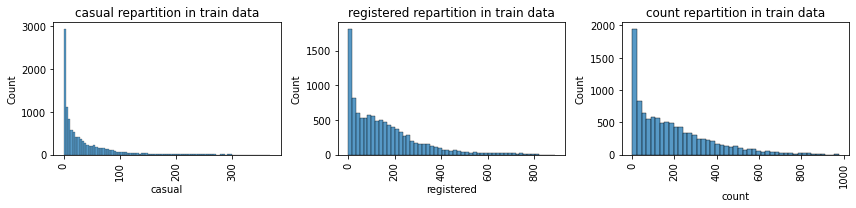

In [150]:
plt.figure(figsize=(12,3))
plot_iter = 1
for k in df_output.columns :
    plt.subplot(1,3,plot_iter)
    y = df_output.loc[:,k]
    sns.histplot(y)
    plt.title(k + " repartition in train data")
    plt.xticks(rotation=90)
    plot_iter += 1
plt.tight_layout()

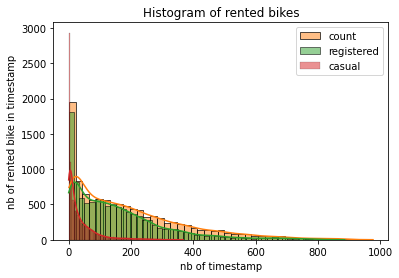

In [137]:
colors = sns.color_palette('tab10')
i=0
for k in ["count","registered", "casual"]:
    i+=1
    sns.histplot(data=df_output, x=k,  kde=True, label=k,color=colors[i])
    plt.legend()
plt.xlabel("nb of timestamp")
plt.ylabel("nb of rented bike in timestamp")
plt.title("Histogram of rented bikes")
plt.show()

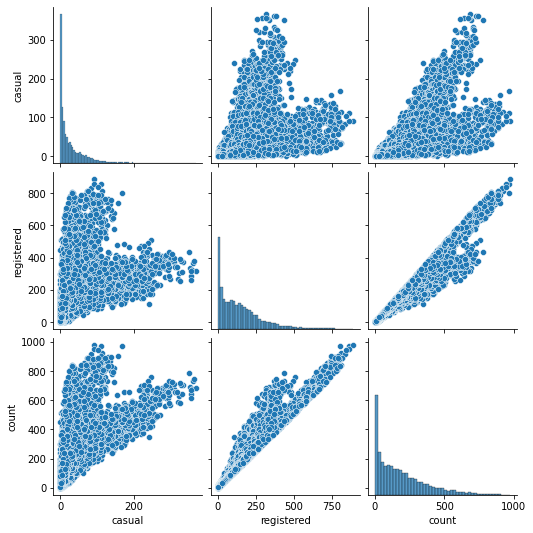

In [163]:
sns.pairplot(df_output)
# plt.title("Pair plot of the counts")

Subscriber rentals account for much of the rental trend, as there is almost a straight line between count and registered.

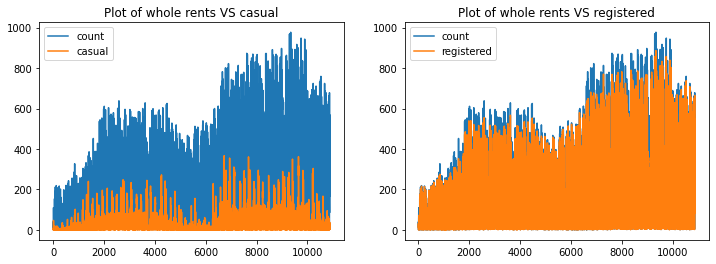

In [183]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(df_output["count"], label = "count")
plt.plot(df_output["casual"], label = "casual")
plt.legend()
plt.title("Plot of whole rents VS casual")

plt.subplot(1,2,2)
plt.plot(df_output["count"], label = "count")
plt.plot(df_output["registered"], label = "registered")
plt.legend()
plt.title("Plot of whole rents VS registered")

plt.show()

It seems that there is a real seasonality in these data. 

Text(0.5, 1.0, 'Plot of some rents VS casual')

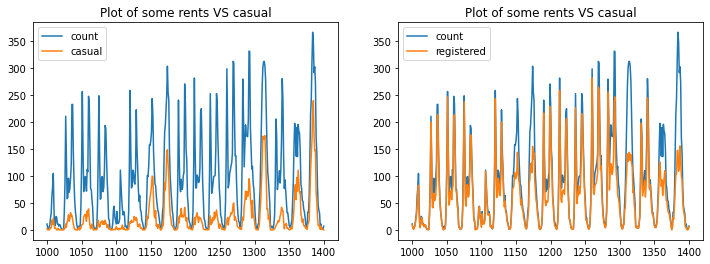

In [184]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(df_output.loc[1000:1400,"count"], label = "count")
plt.plot(df_output.loc[1000:1400,"casual"], label = "casual")
plt.legend()
plt.title("Plot of some rents VS casual")


plt.subplot(1,2,2)
plt.plot(df_output.loc[1000:1400,"count"], label = "count")
plt.plot(df_output.loc[1000:1400,"registered"], label = "registered")
plt.legend()
plt.title("Plot of some rents VS casual")



In [236]:
# transformed_output = pd.DataFrame()


def extend_one_row(train, idx):
    ## copy the row "count" types, and add the column "contract" taking values "casual" or "registered"
    tmp = train.loc[[idx],:].copy()
    n_casual = tmp["casual"].values[0]
    n_count = tmp["count"].values[0]
    tmp.loc[:,"contract"] = "registered"
    tmp = pd.concat([tmp]*n_count, ignore_index=True) # Ignores the index
    tmp.loc[:n_casual,"contract"]="casual"
    return tmp

## lop on whole index and concatenate 
# extended_data = pd.DataFrame()
# for idx in df_output.index[2000:3000] :
#     tmp = extend_one_row(train, idx)
#     extended_data = pd.concat((extended_data, tmp), axis=0)
# extended_data = extended_data.drop(["casual","registered","count"], axis=1)
# extended_data.to_csv(RES_PATH+"extended_train.csv")
extended_data = pd.read_csv(RES_PATH+"extended_train.csv", index_col=0)
extended_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,contract
0,2011-05-10 06:00:00,2,0,1,1,17.22,21.21,67,8.9981,casual
1,2011-05-10 06:00:00,2,0,1,1,17.22,21.21,67,8.9981,casual
2,2011-05-10 06:00:00,2,0,1,1,17.22,21.21,67,8.9981,casual
3,2011-05-10 06:00:00,2,0,1,1,17.22,21.21,67,8.9981,casual
4,2011-05-10 06:00:00,2,0,1,1,17.22,21.21,67,8.9981,casual


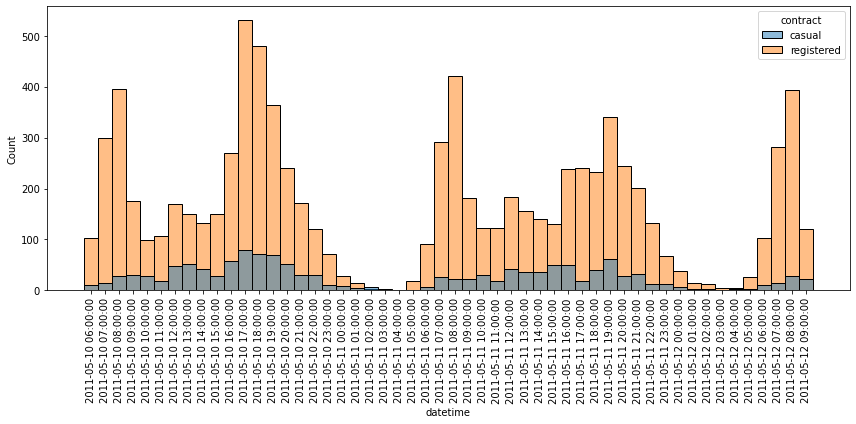

In [246]:
plt.figure(figsize=(12,6))
sns.histplot(data = extended_data.iloc[:10000], x="datetime", hue="contract")
plt.xticks(rotation=90)
plt.tight_layout()

<a id ="section1.1.2"></a>
[back to menu](#menu)
### 1.1.2 Registered rent as time Serie

In [309]:
## convert time :
d = train.datetime
d = pd.to_datetime(d, yearfirst=True)
train.loc[:,"datetime"] = d

In [463]:
## check if the timeline is complete : 
d = train.datetime
d = pd.to_datetime(d, yearfirst=True)
d

0       2011-01-01 00:00:00
1       2011-01-01 01:00:00
2       2011-01-01 02:00:00
3       2011-01-01 03:00:00
4       2011-01-01 04:00:00
                ...        
10881   2012-12-19 19:00:00
10882   2012-12-19 20:00:00
10883   2012-12-19 21:00:00
10884   2012-12-19 22:00:00
10885   2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: datetime64[ns]

In [467]:
complete_timeline = pd.date_range(start = '2011-01-01 00:00:00', end = '2012-12-19 23:00:00' , freq="H")
complete_timeline.difference(d.values)

DatetimeIndex(['2011-01-02 05:00:00', '2011-01-03 02:00:00',
               '2011-01-03 03:00:00', '2011-01-04 03:00:00',
               '2011-01-05 03:00:00', '2011-01-06 03:00:00',
               '2011-01-07 03:00:00', '2011-01-11 03:00:00',
               '2011-01-11 04:00:00', '2011-01-12 03:00:00',
               ...
               '2012-11-30 14:00:00', '2012-11-30 15:00:00',
               '2012-11-30 16:00:00', '2012-11-30 17:00:00',
               '2012-11-30 18:00:00', '2012-11-30 19:00:00',
               '2012-11-30 20:00:00', '2012-11-30 21:00:00',
               '2012-11-30 22:00:00', '2012-11-30 23:00:00'],
              dtype='datetime64[ns]', length=6370, freq=None)

it seems that many values are missing !!! Let's interpolate them. 

In [468]:
min(train.datetime)

Timestamp('2011-01-01 00:00:00')

In [469]:
ts_complete = pd.date_range(start =min(train.datetime),
                    end = max(train.datetime), freq="H")


In [315]:
def extend_one_row_n_copy(train, idx, n_copy):
    ## copy the row "count" types, and add the column "contract" taking values "casual" or "registered"
    tmp = train.loc[[idx],:].copy()
    tmp = tmp.drop(["casual","registered","count"], axis=1)
    tmp = pd.concat([tmp]*n_copy, ignore_index=True) # Ignores the index
    return tmp

df_registered = pd.DataFrame()
for idx in df_output.index[200:300] :
    n_copy = train.loc[idx,"registered"]
    if n_copy>0:
        tmp = extend_one_row_n_copy(train, idx, n_copy)
        df_registered = pd.concat((df_registered, tmp), axis=0)
        
        ## not used, to be removed

In [333]:
ts_registered = pd.Series(data=train.loc[:,"registered"].values, index=train.loc[:,"datetime"], name = "registered")
ts_casual = pd.Series(data=train.loc[:,"casual"].values, index=train.loc[:,"datetime"], name = "casual")
ts_count = pd.Series(data=train.loc[:,"count"].values, index=train.loc[:,"datetime"], name = "count")

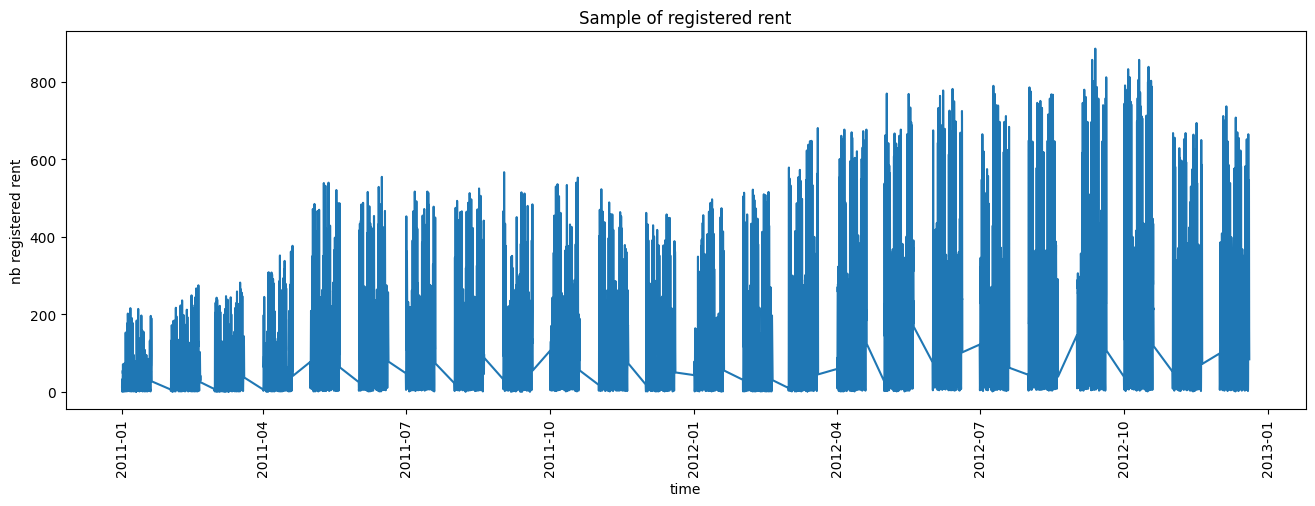

In [334]:
# Draw ts plot
plt.figure(figsize=(16,5), dpi=100)
plt.plot(ts_sample.index, ts_sample.values, color='tab:blue')
plt.gca().set(title="Sample of registered rent", xlabel="time", ylabel="nb registered rent")
plt.xticks(rotation=90, fontsize=10)
plt.show()

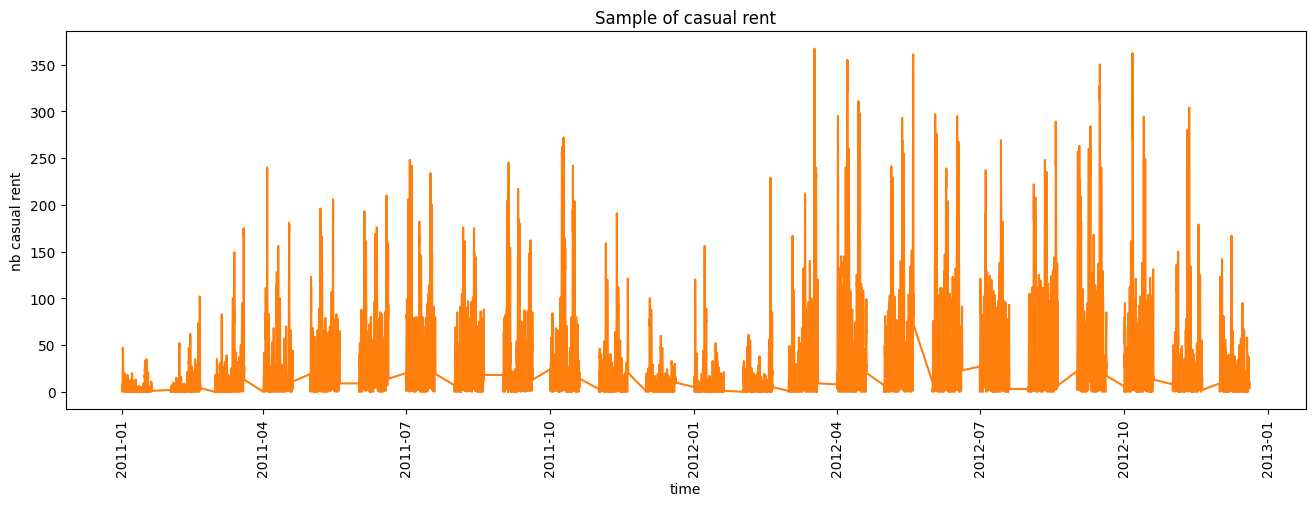

In [339]:
# Draw ts plot
plt.figure(figsize=(16,5), dpi=100)
plt.plot(ts_casual.index, ts_casual.values, color='tab:orange')
plt.gca().set(title="Sample of casual rent", xlabel="time", ylabel="nb casual rent")
plt.xticks(rotation=90, fontsize=10)
plt.show()

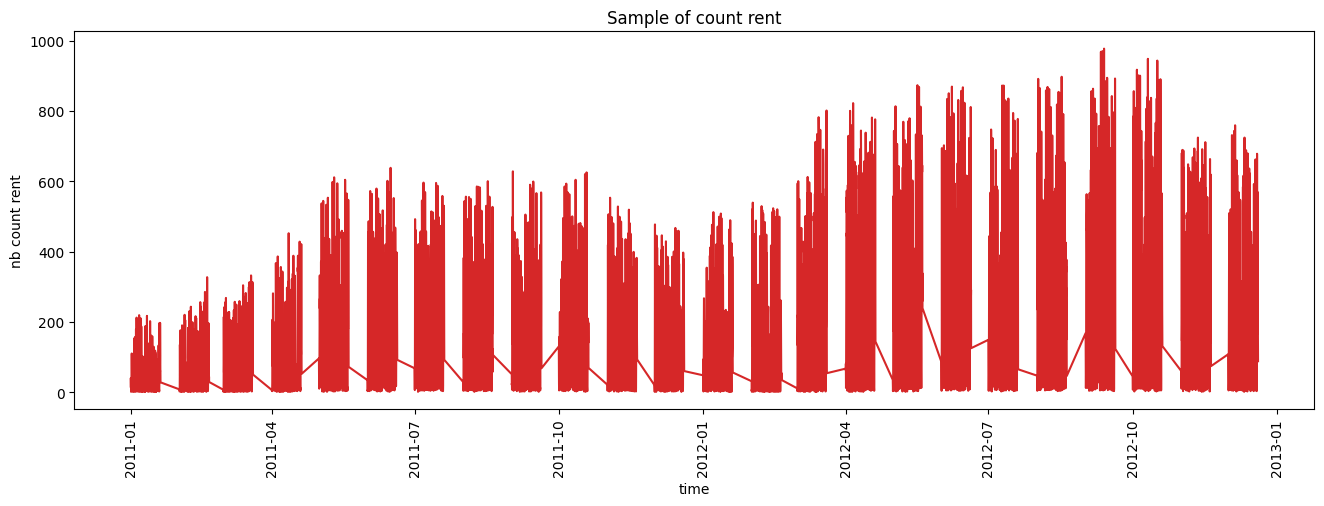

In [340]:
# Draw ts plot
plt.figure(figsize=(16,5), dpi=100)
plt.plot(ts_count.index, ts_count.values, color='tab:red')
plt.gca().set(title="Sample of count rent", xlabel="time", ylabel="nb count rent")
plt.xticks(rotation=90, fontsize=10)
plt.show()

#### Seasonality :

In [431]:
ts = ts_registered.copy().rename({"registered":"value"})
contrat = "Registered" ## type of count
df = ts.reset_index().rename(columns={"registered":"value"})

# Prepare data
df.loc[:,'month'] = [d.month_name() for d in ts.index]
df.loc[:,'day'] = [d.day_name() for d in ts.index]
df.loc[:,'hour'] = [d.hour for d in ts.index]


Let's see the daily seasonality :

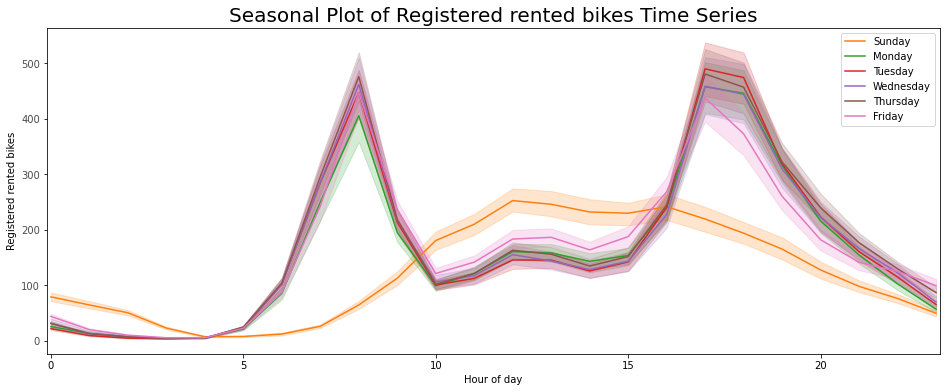

In [432]:
days = pd.unique(df.loc[:,'day'])
# Prep Colors
np.random.seed(100)
mycolors = sns.color_palette("tab10", len(days))

# Draw Plot
plt.figure(figsize=(16,6))#, dpi= 80)
for i, day in enumerate(days):
    if i > 0:        
        sns.lineplot(x='hour', y="value", data=df.loc[df.day==day,:], 
                 color=mycolors[i], label=day)

# Decoration
plt.gca().set(xlim=(-0.1, 23.1), ylabel=contrat+' rented bikes', xlabel='Hour of day')
plt.yticks(fontsize=10, alpha=.7)
plt.title("Seasonal Plot of "+contrat+" rented bikes Time Series", fontsize=20)
plt.show()

Clearly, the sunday rents are really different from other days ! I think to have a better performance, it is a good idea to treat the Sunday as another modelisation. 


To be sure that there is no other trend in the time serie, let's zoom out to the "month/day" scale.

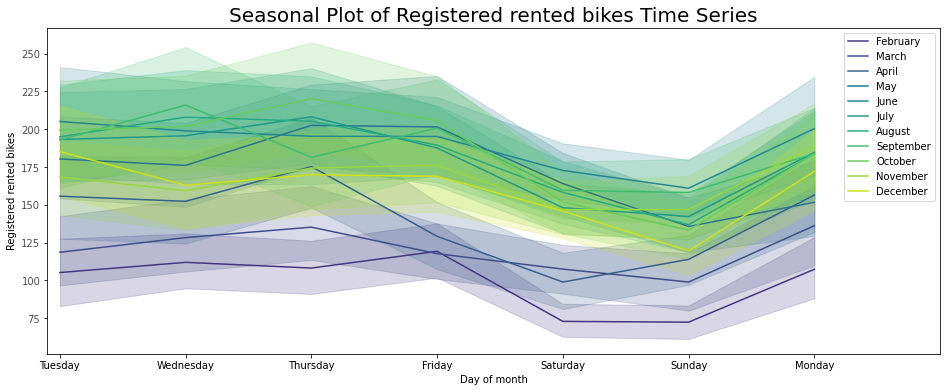

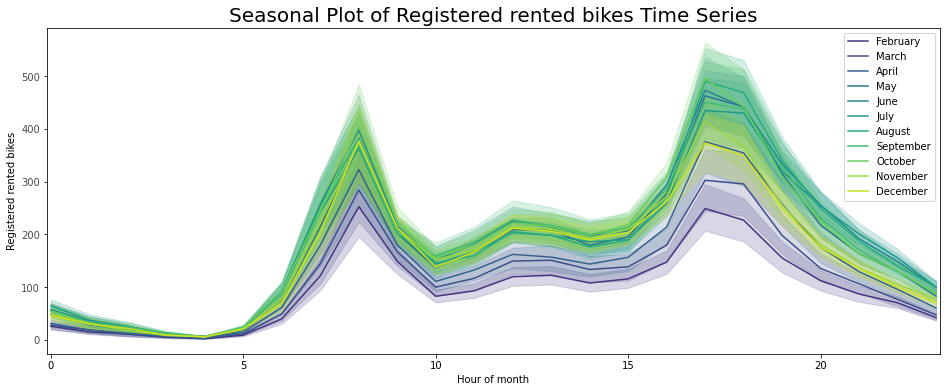

In [433]:
months = pd.unique(df.loc[:,'month'])
mycolors = sns.color_palette("viridis", len(months))

## plot months VS day
plt.figure(figsize=(16,6))#, dpi= 80)
for i, month in enumerate(months):
    if i > 0:        
        sns.lineplot(x='day', y='value', data=df.loc[df.month==month,:], 
                 color=mycolors[i], label=month)
plt.gca().set(xlim=(-0.1, 7), ylabel=contrat+' rented bikes', xlabel='Day of month')
plt.yticks(fontsize=10, alpha=.7)
plt.title("Seasonal Plot of "+contrat+" rented bikes Time Series", fontsize=20)
plt.show()

## plot months VS hour
plt.figure(figsize=(16,6))#, dpi= 80)
for i, month in enumerate(months):
    if i > 0:        
        sns.lineplot(x='hour', y='value', data=df.loc[df.month==month,:], 
                 color=mycolors[i], label=month)
plt.gca().set(xlim=(-0.1, 23.1), ylabel=contrat+' rented bikes', xlabel='Hour of month')
plt.yticks(fontsize=10, alpha=.7)
plt.title("Seasonal Plot of "+contrat+" rented bikes Time Series", fontsize=20)
plt.show()

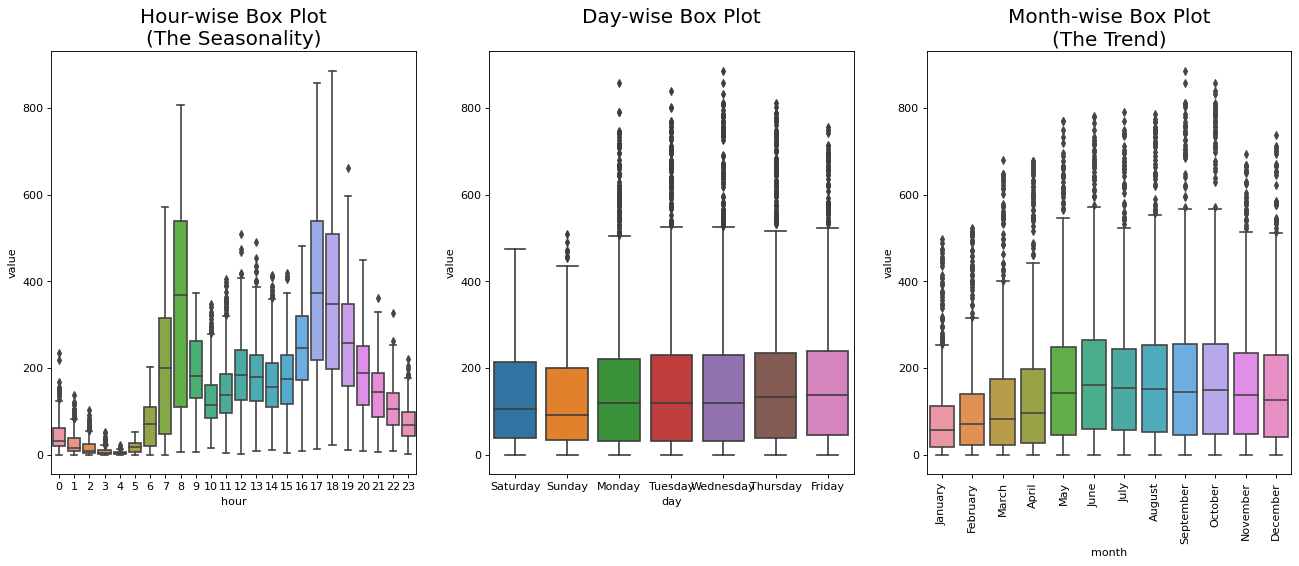

In [434]:
# Draw Plot
fig, axes = plt.subplots(1, 3, figsize=(20,7), dpi= 80)
sns.boxplot(x='hour', y='value', data=df, ax=axes[0])
sns.boxplot(x='day', y='value', data=df, ax=axes[1])
sns.boxplot(x='month', y='value', data=df, ax=axes[2])

# Set Title
axes[0].set_title('Hour-wise Box Plot\n(The Seasonality)', fontsize=18); 
axes[1].set_title('Day-wise Box Plot\n', fontsize=18); 
axes[2].set_title('Month-wise Box Plot\n(The Trend)', fontsize=18)
plt.xticks(rotation=90)
plt.show()

In [435]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

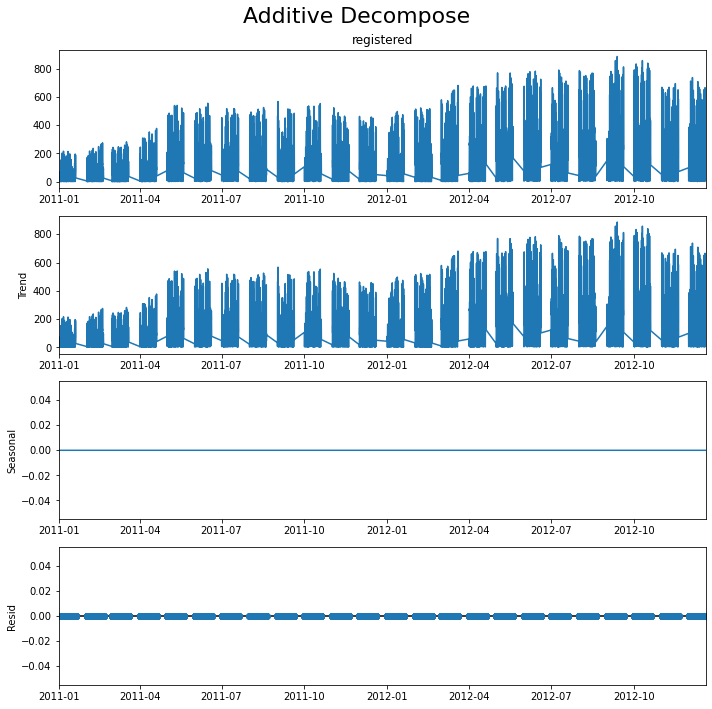

In [461]:
# Multiplicative Decomposition 
tmp = ts.copy()
# tmp = tmp +1
## reindex to add the periode every 24 hours :
# tmp.reindex()
result_add = seasonal_decompose(tmp, period = 1, model='additive')#£, extrapolate_trend='freq', period=)

plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.tight_layout()

In [450]:
tmp

datetime
2011-01-01 00:00:00     13
2011-01-01 01:00:00     32
2011-01-01 02:00:00     27
2011-01-01 03:00:00     10
2011-01-01 04:00:00      1
                      ... 
2012-12-19 19:00:00    329
2012-12-19 20:00:00    231
2012-12-19 21:00:00    164
2012-12-19 22:00:00    117
2012-12-19 23:00:00     84
Name: registered, Length: 10886, dtype: int64

<a id ="section1.2"></a>
[back to menu](#menu)

## 1.2. Categorical data :
Let's first focus on the categorical data : 

In [33]:
df_cat = train.loc[:,["season","holiday","workingday", "weather"]]
dict_cat = {"season" : {1:"spring", 2 : "summer", 3 : "fall", 4 : "winter" },
            "weather" : {1: "w_very_good", 2: "w_good", 3: "w_bad", 4: "w_very_bad"}
            }

df_dum = df_cat.copy()
for k in dict_cat.keys() :
    corresp = dict_cat[k]
    cat = df_cat.loc[:,k].replace(corresp)
    df_cat.loc[:,k] = cat
    dummies = pd.get_dummies(cat)
    df_dum = pd.concat((df_dum, dummies), axis=1)

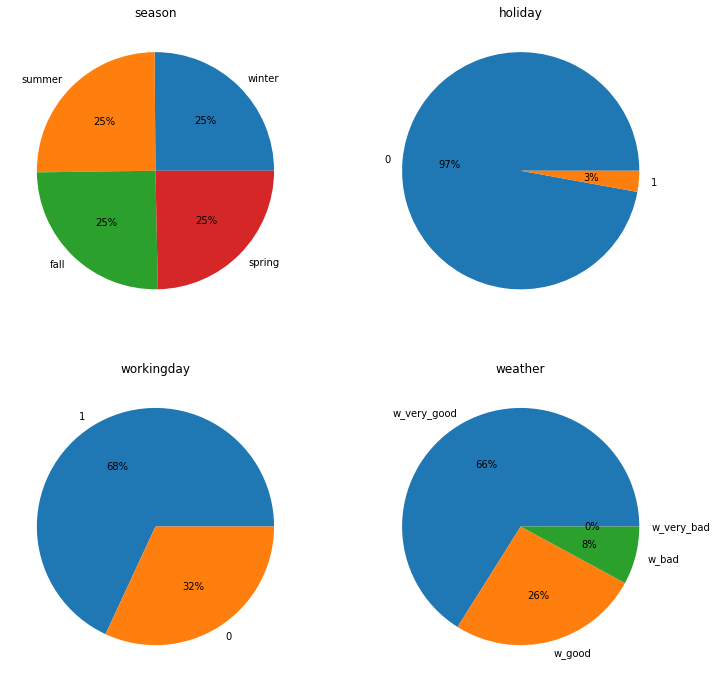

In [52]:
plt.figure(figsize=(12,12))
colors = sns.color_palette('tab10')[0:5]
plot_iter = 1
for k in df_cat.columns : 
    plt.subplot(2,2,plot_iter)
    tmp = df_cat.loc[:,k].value_counts()
    plt.title(k)
    plt.pie(tmp.values, labels = tmp.index,
            colors = colors, autopct='%.0f%%')
    plot_iter += 1

Let's ponderate the disrtibution with the number of rented bikes (the number to be predicted)